In [197]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("dark")
# for constant figure size
BIG_FIG = (15,5)
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [198]:
data = pd.read_csv("https://raw.githubusercontent.com/eduardo-vicentini/challenge/master/data_comexstat.csv", encoding="ISO-8859-1")
data['date']  = pd.to_datetime(data['date'])
data

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
117962,2019-12-01,wheat,SP,Lebanon,Import,Sea,5.769,6726.0
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


## Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

In [199]:
export = data[data["type"] == "Export"]
df_import =  data[data["type"] == "Import"]
export.head()

,date,product,state,country,type,route,tons,usd
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
5,1997-01-01,corn,MS,Paraguay,Export,Ground,40.000,38700.0
9,1997-01-01,corn,PR,Netherlands,Export,Sea,170000.000,20000000.0
10,1997-01-01,corn,PR,Paraguay,Export,Ground,258.300,386733.0


In [200]:
soybean_oil = data[data["product"] == "soybean_oil"][['date', 'usd']]
soybean = data[data["product"] == "soybeans"][['date', 'usd']]
soybean_meal = data[data["product"] == "soybean_meal"][['date', 'usd']]

soybean_oil = soybean_oil.groupby("date").sum()
soybean = soybean.groupby("date").sum()
soybean_meal = soybean_meal.groupby("date").sum()

In [201]:
soybean_oil

,usd
date,
1997-01-01,41311398.0
1997-02-01,24131677.0
1997-03-01,15176561.0
1997-04-01,86514805.0
1997-05-01,85257501.0
...,...
2019-08-01,72200383.0
2019-09-01,54187441.0
2019-10-01,52866255.0


### Total Monthly

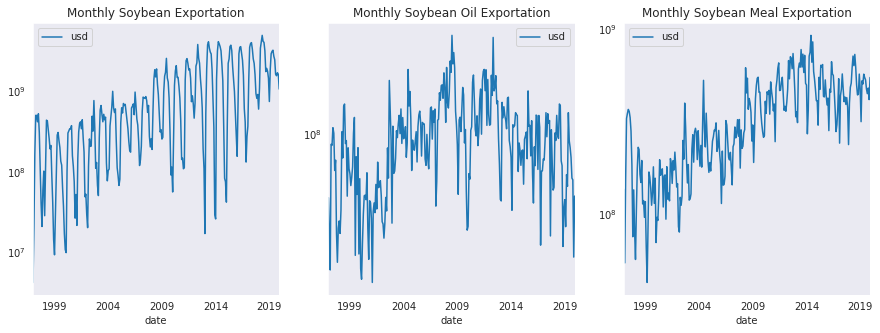

In [202]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=BIG_FIG)
soybean.plot(title="Monthly Soybean Exportation", logy=True, ax=axes[0])


soybean_oil.plot(title="Monthly Soybean Oil Exportation", logy=True, ax=axes[1])


soybean_meal.plot(title="Monthly Soybean Meal Exportation", logy=True,ax=axes[2])
plt.show()

### Anual

In [203]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['year'] = df['date'].dt.year
    
    X = df[['year', 'usd']]  
    return X

In [204]:
soybean_year = create_features(soybean)
soybean_meal_year = create_features(soybean_meal)
soybean_oil_year = create_features(soybean_oil)

In [205]:
soybean_oil_year = soybean_oil_year.groupby("year").sum()
soybean_year = soybean_year.groupby("year").sum()
soybean_meal_year = soybean_meal_year.groupby("year").sum()

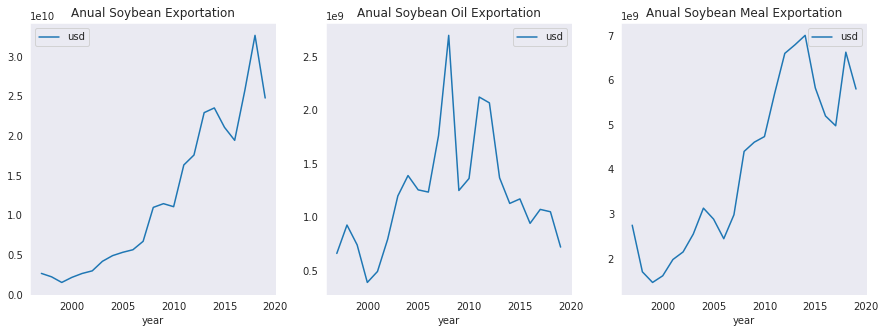

In [206]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=BIG_FIG)

soybean_year.plot(title="Anual Soybean Exportation", ax=axes[0])


soybean_oil_year.plot(title="Anual Soybean Oil Exportation", ax=axes[1])


soybean_meal_year.plot(title="Anual Soybean Meal Exportation", ax=axes[2])
plt.show()

## brazil's three most exported products (in usd terms)

In [207]:
export.drop(columns=["state", "country", "type", "route"], inplace=True)

In [208]:
products = export.groupby("product").sum()
products

,tons,usd
product,,
corn,2.789230e+08,5.196579e+10
soybean_meal,2.978233e+08,9.335736e+10
soybean_oil,3.899132e+07,2.708342e+10
soybeans,7.339587e+08,2.762390e+11
sugar,2.719595e+08,9.806823e+10
wheat,7.652557e+06,1.767894e+09


In [209]:
big3 = products.nlargest(3, columns=["usd"], keep="all")
big3

,tons,usd
product,,
soybeans,7.339587e+08,2.762390e+11
sugar,2.719595e+08,9.806823e+10
soybean_meal,2.978233e+08,9.335736e+10


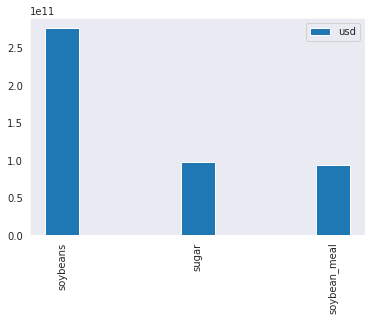

In [210]:

plt.show()
plt.bar(big3.index, big3.usd, width = 0.25, label="usd")
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

## Main routes through which Brazil have been exporting ‘corn’ in the last few years (After 2017)

In [211]:
export = data[data["type"] == "Export"]
corn = export[export["product"] == "corn"]
corn

,date,product,state,country,type,route,tons,usd
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
5,1997-01-01,corn,MS,Paraguay,Export,Ground,40.000,38700.0
9,1997-01-01,corn,PR,Netherlands,Export,Sea,170000.000,20000000.0
10,1997-01-01,corn,PR,Paraguay,Export,Ground,258.300,386733.0
...,...,...,...,...,...,...,...,...
117265,2019-12-01,corn,SP,Vietnam,Export,Sea,2575.793,402284.0
117266,2019-12-01,corn,TO,Egypt,Export,Sea,27908.815,4433950.0
117267,2019-12-01,corn,TO,Kuwait,Export,Sea,1293.930,229003.0
117268,2019-12-01,corn,TO,Philippines,Export,Air,0.007,27.0


In [212]:
corn = corn[corn["date"] > "2016-12-30"]
corn

,date,product,state,country,type,route,tons,usd
90622,2017-01-01,corn,GO,Dominican Republic,Export,Sea,795.679,147710.0
90623,2017-01-01,corn,GO,Ecuador,Export,Air,0.122,1504.0
90624,2017-01-01,corn,GO,Egypt,Export,Sea,199.950,533884.0
90625,2017-01-01,corn,GO,Iran,Export,Sea,17.680,2791.0
90626,2017-01-01,corn,GO,Iran,Export,Sea,600.000,85626.0
...,...,...,...,...,...,...,...,...
117265,2019-12-01,corn,SP,Vietnam,Export,Sea,2575.793,402284.0
117266,2019-12-01,corn,TO,Egypt,Export,Sea,27908.815,4433950.0
117267,2019-12-01,corn,TO,Kuwait,Export,Sea,1293.930,229003.0
117268,2019-12-01,corn,TO,Philippines,Export,Air,0.007,27.0


In [213]:
routes = corn.groupby("route").sum()
routes

,tons,usd
route,,
Air,4.162630e+02,1.880937e+06
Ground,4.824573e+04,1.130397e+08
Other,2.624365e+05,4.359135e+07
River,3.500016e+06,5.654711e+08
Sea,9.002341e+07,1.498535e+10


In [214]:
routes = routes.sort_values("usd")
routes

,tons,usd
route,,
Air,4.162630e+02,1.880937e+06
Other,2.624365e+05,4.359135e+07
Ground,4.824573e+04,1.130397e+08
River,3.500016e+06,5.654711e+08
Sea,9.002341e+07,1.498535e+10


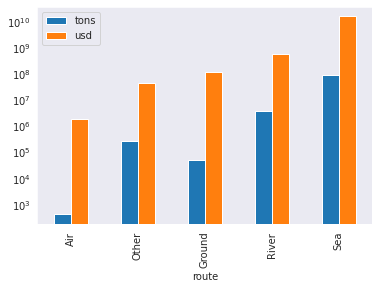

In [215]:
routes.plot(kind='bar', logy=True)
plt.show()

## Are there differences in the relative importance of routes depending on the product?

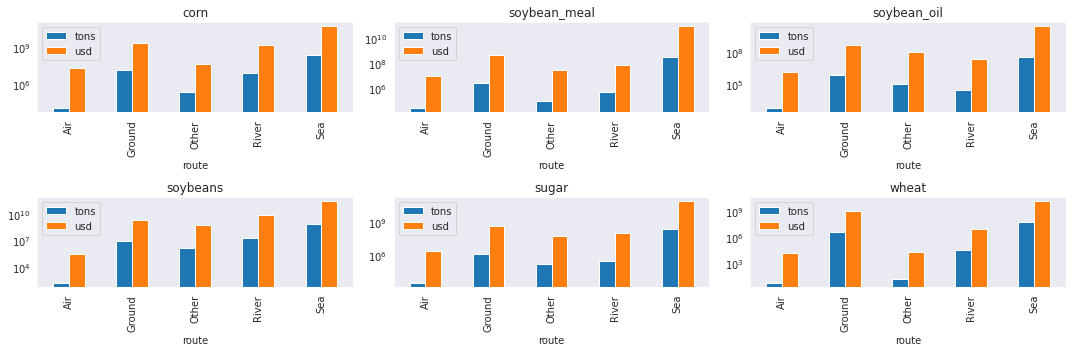

In [216]:
products = []
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=BIG_FIG)

for i, product in enumerate(pd.unique(data['product'].values)):
    p = data[data["product"] == product]
    routes = p.groupby("route").sum()

    products.append(routes)
    if i >= 3:
      j = i - 3
    else:
      j = i
    routes.plot(kind='bar', logy=True, title=product, ax=axes[int(i/3), j])
    
    #plt.title(product)
    
fig.tight_layout()
plt.show()

USD and tons have the same trend, so we will use only one

In [217]:
serie = []
i=0
for product in products:
    i += 1
    values = []
    for item in products[0].index:
        if item == "River" and i == len(products):
            values.append(0)
        else:
            values.append(product.loc[item]["usd"])
    serie.append(values)


routes = pd.DataFrame(serie, columns=products[0].index, index=pd.unique(data['product'].values))
routes

route,Air,Ground,Other,River,Sea
corn,22016389.0,2.573138e+09,46651009.0,1.666881e+09,5.061211e+10
soybean_meal,8442259.0,4.615589e+08,30544649.0,7.182727e+07,9.326658e+10
soybean_oil,1365993.0,4.868319e+08,102207657.0,2.599700e+07,2.717758e+10
soybeans,313105.0,2.345389e+09,572221983.0,7.214311e+09,2.686037e+11
sugar,2471541.0,5.077324e+08,59709007.0,1.039980e+08,9.740790e+10
wheat,17564.0,8.841966e+08,23055.0,0.000000e+00,1.351858e+10


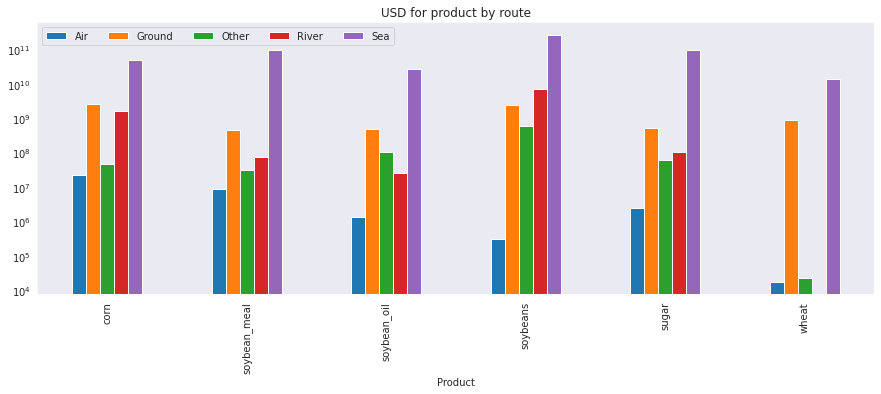

In [218]:
routes.plot(kind='bar', logy=True, figsize=BIG_FIG, title="USD for product by route")
plt.xlabel("Product")
plt.legend(loc='upper left', ncol=5)
plt.show()

### Characteristics of the transport

All the products have as principal route the sea.

As a second way of transporting, the ground or river is the choice. 

## Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

This question can be more interesting with a separation of the export and import partner

In [219]:
df_import

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
6,1997-01-01,corn,PE,Argentina,Import,Sea,6300.000,847350.0
7,1997-01-01,corn,PE,Uruguay,Import,Sea,2625.000,324188.0
...,...,...,...,...,...,...,...,...
117956,2019-12-01,wheat,RS,Argentina,Import,Sea,89303.000,17340968.0
117958,2019-12-01,wheat,SC,Paraguay,Import,Ground,500.000,99750.0
117959,2019-12-01,wheat,SC,Paraguay,Import,Ground,1000.000,206000.0
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0


In [220]:
export_corn_partners = export[export['product'] == "corn"]
export_sugar_partners = export[export['product'] == 'sugar']
import_corn_partners = df_import[df_import['product'] == "corn"]
import_sugar_partners = df_import[df_import['product'] == "corn"]

In [221]:
export_corn_partners = export_corn_partners[export_corn_partners["date"] > "2016-12-30"]
export_sugar_partners = export_sugar_partners[export_sugar_partners["date"] > "2016-12-30"]
import_corn_partners = import_corn_partners[import_corn_partners["date"] > "2016-12-30"]
import_sugar_partners = import_sugar_partners[import_sugar_partners["date"] > "2016-12-30"]

In [222]:
import_sugar_partners

,date,product,state,country,type,route,tons,usd
90619,2017-01-01,corn,AL,Argentina,Import,Sea,9759.000,1805225.0
90620,2017-01-01,corn,CE,Argentina,Import,Sea,29933.422,5586005.0
90621,2017-01-01,corn,GO,Argentina,Import,Ground,5.000,20000.0
90635,2017-01-01,corn,GO,United States,Import,Sea,19.958,139098.0
90646,2017-01-01,corn,MS,Paraguay,Import,Ground,3500.000,529050.0
...,...,...,...,...,...,...,...,...
117239,2019-12-01,corn,RS,United States,Import,Sea,18.144,195323.0
117245,2019-12-01,corn,SC,Paraguay,Import,Ground,4750.000,631500.0
117246,2019-12-01,corn,SC,Paraguay,Import,Ground,7000.000,891000.0
117247,2019-12-01,corn,SC,Paraguay,Import,Ground,52000.000,6553703.0


In [223]:
export_corn_partners = export_corn_partners.groupby("country").sum().nlargest(3, columns=["usd"], keep="all")
export_sugar_partners = export_sugar_partners.groupby("country").sum().nlargest(3, columns=["usd"], keep="all")
import_corn_partners = import_corn_partners.groupby("country").sum().nlargest(3, columns=["usd"], keep="all")
import_sugar_partners = import_sugar_partners.groupby("country").sum().nlargest(3, columns=["usd"], keep="all")

In [224]:
import_corn_partners

,tons,usd
country,,
Paraguay,2842287.275,374158249.0
Argentina,819267.684,154907150.0
United States,2221.313,20830122.0


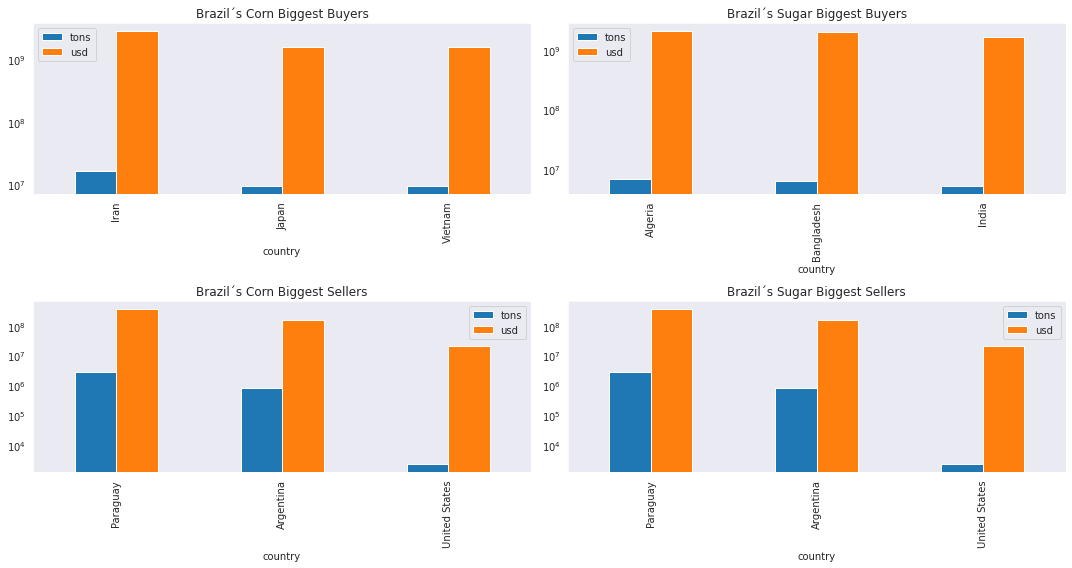

In [225]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

export_corn_partners.plot(kind="bar", logy=True, title = "Brazil´s Corn Biggest Buyers", ax=axes[0,0])


export_sugar_partners.plot(kind="bar", logy=True, title = "Brazil´s Sugar Biggest Buyers", ax=axes[0,1])


import_corn_partners.plot(kind="bar", logy=True, title = "Brazil´s Corn Biggest Sellers", ax=axes[1,0])


import_sugar_partners.plot(kind="bar", logy=True, title = "Brazil´s Sugar Biggest Sellers", ax=axes[1,1])

fig.tight_layout()
plt.show()


In [226]:
def answ(countries, element):
  print(f"The biggest {element} are:")
  for i, country in enumerate(countries):
    print(f"{i+1} - {country}")
  print()

In [227]:
answ(export_corn_partners.index, "Corn Buyers")
answ(import_corn_partners.index, "Corn Sellers")
answ(export_sugar_partners.index, "Sugar Buyers")
answ(import_sugar_partners.index, "Sugar Sellers")

The biggest Corn Buyers are:
1 - Iran
2 - Japan
3 - Vietnam

The biggest Corn Sellers are:
1 - Paraguay
2 - Argentina
3 - United States

The biggest Sugar Buyers are:
1 - Algeria
2 - Bangladesh
3 - India

The biggest Sugar Sellers are:
1 - Paraguay
2 - Argentina
3 - United States



## For each of the products in the dataset, show the 5 most important states in terms of exports?

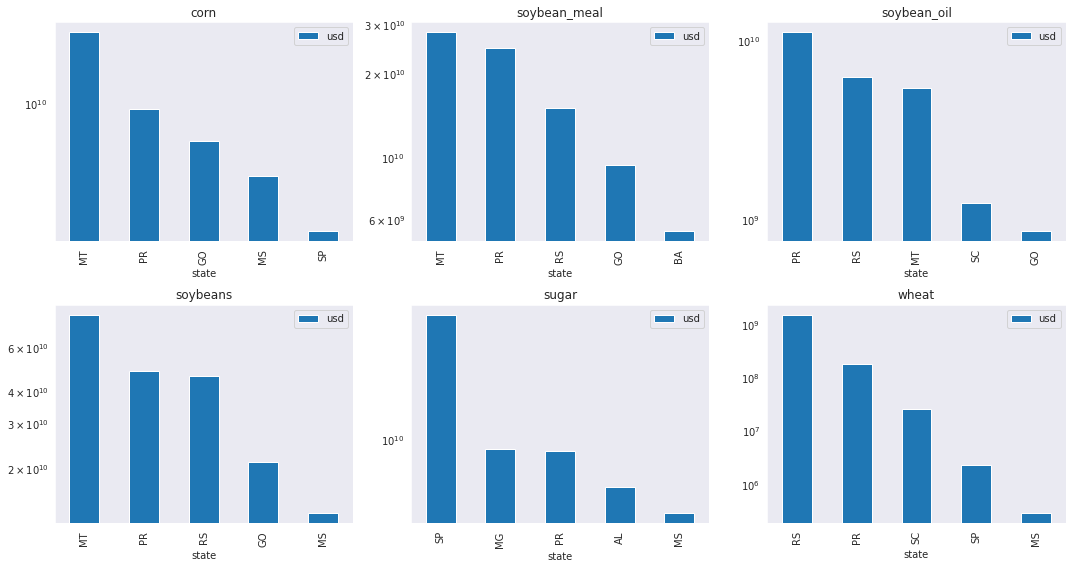

In [228]:
products = []
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for i, product in enumerate(pd.unique(export['product'].values)):
    p = export[export["product"] == product].drop("tons", axis=1)
    routes = p.groupby("state").sum().nlargest(5, columns=["usd"], keep="all")

    products.append(routes)
    if i >= 3:
      j = i - 3
    else:
      j = i
    routes.plot(kind='bar', logy=True, title=product, ax=axes[int(i/3), j])



    plt.title(product)
    
fig.tight_layout()
plt.show()



In [229]:
def answ(products, names):
  for i, product in enumerate(products):
    print(f"The 5 states that most export {names[i]} are:")
    for i, state in enumerate(product.index):
      print(f"{i+1} - {state} - {product.loc[state]['usd']}")
    print()


answ(products, pd.unique(export['product'].values))

The 5 states that most export corn are:
1 - MT - 28375516035.0
2 - PR - 9160511995.0
3 - GO - 5706990655.0
4 - MS - 3405430680.0
5 - SP - 1511121926.0

The 5 states that most export soybean_meal are:
1 - MT - 27994539842.0
2 - PR - 24649962821.0
3 - RS - 15007385729.0
4 - GO - 9421430703.0
5 - BA - 5439265638.0

The 5 states that most export soybean_oil are:
1 - PR - 11109102057.0
2 - RS - 6281965055.0
3 - MT - 5434513926.0
4 - SC - 1238810673.0
5 - GO - 855920734.0

The 5 states that most export soybeans are:
1 - MT - 80506781707.0
2 - PR - 48484101052.0
3 - RS - 46136733396.0
4 - GO - 21268827303.0
5 - MS - 13284815678.0

The 5 states that most export sugar are:
1 - SP - 66211861392.0
2 - MG - 8559401218.0
3 - PR - 8270778644.0
4 - AL - 4826419200.0
5 - MS - 3219034929.0

The 5 states that most export wheat are:
1 - RS - 1555925283.0
2 - PR - 183935397.0
3 - SC - 25400089.0
4 - SP - 2267024.0
5 - MS - 275733.0



# Modeling
### Question: What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)?

In [230]:
cov = pd.read_excel("https://github.com/eduardo-vicentini/challenge/blob/master/covariates.xlsx?raw=true", parse_dates=[0])

In [231]:
cov_2 = cov.dropna()

In [232]:
cov_2.head()

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
1,1980-01-01,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000
2,1981-01-01,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000
3,1982-01-01,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954
4,1983-01-01,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250
5,1984-01-01,97.056065,108.037577,84.719333,157.776711,86.066052,103.073418,105.502383,130.442118,112.436498,133.359142,120.144634,128.250479


In [233]:
cov_2['year']  = pd.to_datetime(cov_2['year'])
data['date']  = pd.to_datetime(data['date'])
data.head()

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0


In [234]:
corn = data[data["product"] == "corn"][['date', 'usd']]
soybean = data[data["product"] == "soybeans"][['date', 'usd']]
soybean_meal = data[data["product"] == "soybean_meal"][['date', 'usd']]
soybean_meal.head(10)

,date,usd
19,1997-01-01,119318.0
20,1997-01-01,1414250.0
21,1997-01-01,38378.0
22,1997-01-01,4042100.0
23,1997-01-01,3850162.0
24,1997-01-01,1397150.0
25,1997-01-01,2902485.0
26,1997-01-01,3975031.0
27,1997-01-01,410350.0
28,1997-01-01,587615.0


In [235]:
corn = corn.groupby("date").sum()
soybean = soybean.groupby("date").sum()
soybean_meal = soybean_meal.groupby("date").sum()
corn.head()

,usd
date,
1997-01-01,22348700.0
1997-02-01,18473188.0
1997-03-01,12741296.0
1997-04-01,12645430.0
1997-05-01,6439312.0


In [236]:
corn.tail()

,usd
date,
2019-08-01,1.221947e+09
2019-09-01,1.070322e+09
2019-10-01,1.013438e+09
2019-11-01,7.173578e+08
2019-12-01,7.258093e+08


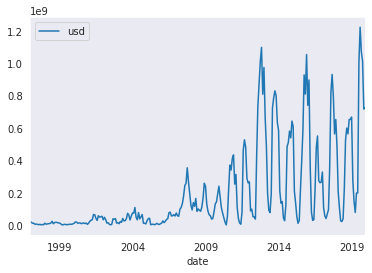

In [237]:
corn.plot()
plt.show()

In [238]:
def split_train_test(df, date='01-01-2017'):
  df_train = df.loc[df.index <= date].copy()
  df_test = df.loc[df.index > date].copy()

  return df_train, df_test

In [239]:
corn_train, corn_test = split_train_test(corn)
soybean_train, soybean_test = split_train_test(soybean)
soybean_meal_train, soybean_meal_test = split_train_test(soybean_meal)

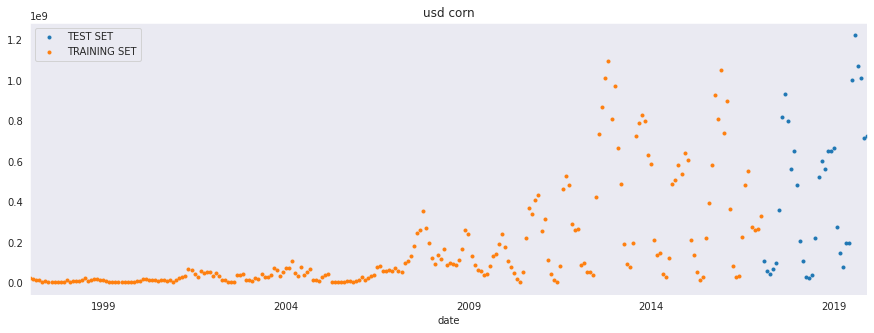

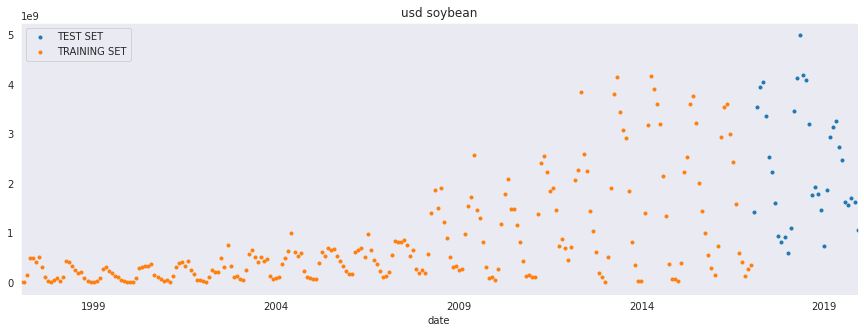

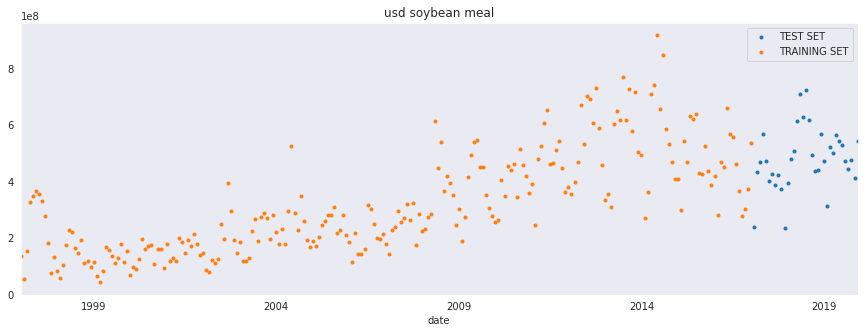

In [240]:
corn_test \
    .rename(columns={'usd': 'TEST SET'}) \
    .join(corn_train.rename(columns={'usd': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='usd corn', style='.')
plt.show()

soybean_test \
    .rename(columns={'usd': 'TEST SET'}) \
    .join(soybean_train.rename(columns={'usd': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='usd soybean', style='.')
plt.show()

soybean_meal_test \
    .rename(columns={'usd': 'TEST SET'}) \
    .join(soybean_meal_train.rename(columns={'usd': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='usd soybean meal', style='.')
plt.show()

In [241]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    
    
    X = df[['month','year']]
    if label:
        y = df[label]
        return X, y
    return X

In [242]:
X_train, y_train = create_features(corn_train, label='usd')
X_test, y_test = create_features(corn_test, label='usd')

In [243]:
X_train

,month,year
date,,
1997-01-01,1,1997
1997-02-01,2,1997
1997-03-01,3,1997
1997-04-01,4,1997
1997-05-01,5,1997
...,...,...
2016-09-01,9,2016
2016-10-01,10,2016
2016-11-01,11,2016


In [244]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=5,
       verbose=False) # Change verbose to True if you want to see it train

[17:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Feature importances

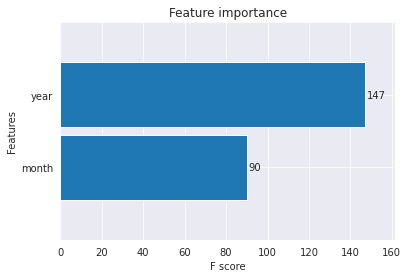

In [245]:
_ = plot_importance(reg, height=0.9)

## Forecast on Test Set

In [246]:
corn_test['usd_Prediction'] = reg.predict(X_test)
corn_all = pd.concat([corn_test, corn_train], sort=False)

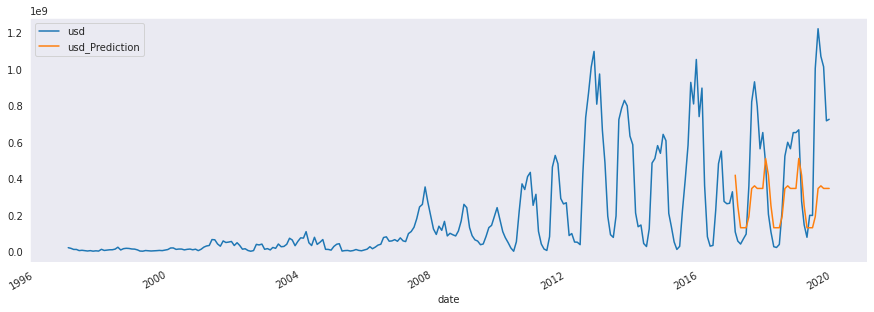

In [247]:
_ = corn_all[['usd','usd_Prediction']].plot(figsize=(15, 5))

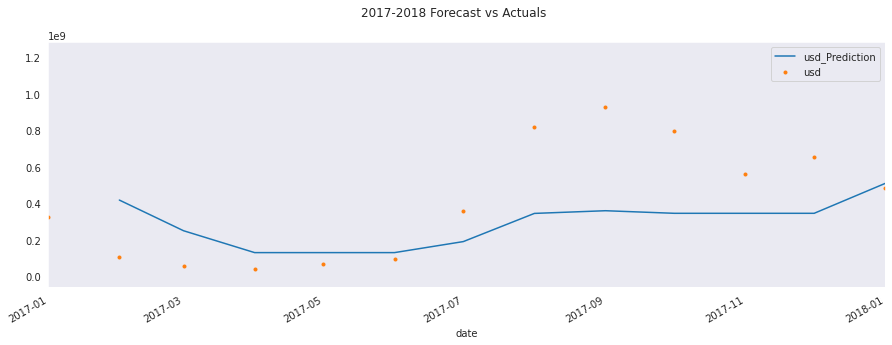

In [248]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = corn_all[['usd_Prediction','usd']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2017', upper='01-01-2018')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('2017-2018 Forecast vs Actuals')

In [249]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [250]:
mean_absolute_percentage_error(y_true=corn_test['usd'],
                   y_pred=corn_test['usd_Prediction'])

98.63430662026326

This method is not producing good results

## Using just anual data and the covariates

In [251]:
def create_year(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['year'] = df['date'].dt.year
     
    return df

In [252]:
corn_year = create_year(corn).groupby("year").sum()
soybean_year = create_year(soybean).groupby("year").sum()
soybean_meal_year = create_year(soybean_meal).groupby("year").sum()

In [253]:
soybean_meal_year.head()

,usd
year,
1997,2.744088e+09
1998,1.698539e+09
1999,1.460211e+09
2000,1.609578e+09
2001,1.974379e+09


In [254]:
def split_train_test(df, test_size=5):
  df_train = df.iloc[:len(df) - test_size].copy()
  df_test = df.iloc[len(df) - test_size:].copy()

  return df_train, df_test

corn_year_train, corn_year_test = split_train_test(corn_year)
soybean_year_train, soybean_year_test = split_train_test(soybean_year)
soybean_meal_year_train, soybean_meal_year_test = split_train_test(soybean_meal_year)

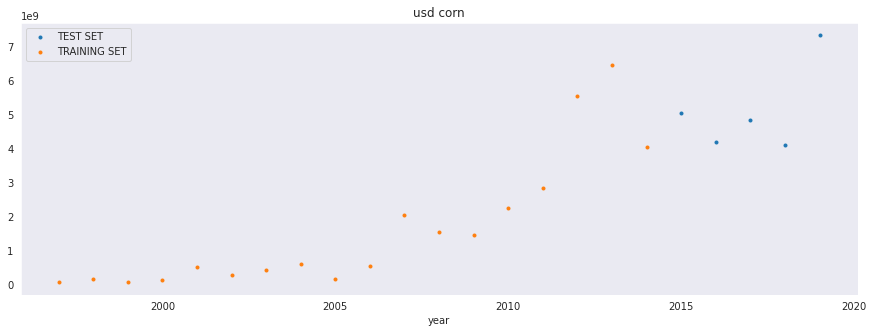

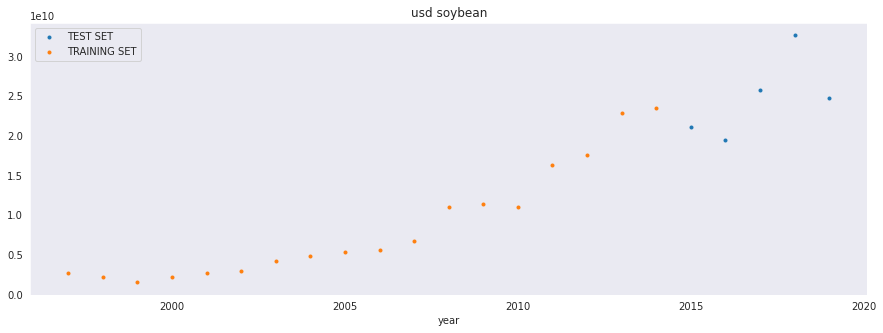

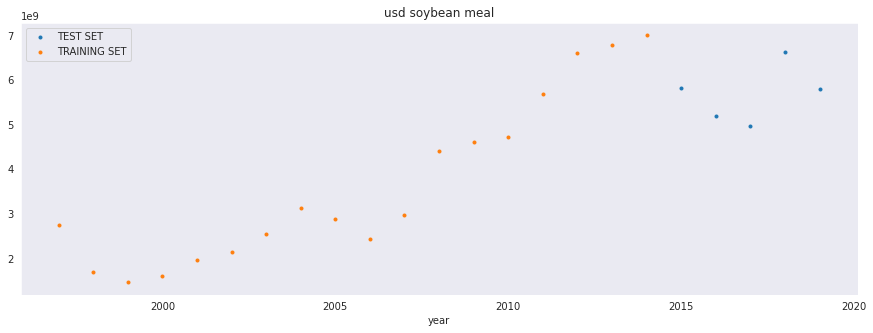

In [255]:
corn_year_test \
    .rename(columns={'usd': 'TEST SET'}) \
    .join(corn_year_train.rename(columns={'usd': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='usd corn', style='.')
plt.show()

soybean_year_test \
    .rename(columns={'usd': 'TEST SET'}) \
    .join(soybean_year_train.rename(columns={'usd': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='usd soybean', style='.')
plt.show()

soybean_meal_year_test \
    .rename(columns={'usd': 'TEST SET'}) \
    .join(soybean_meal_year_train.rename(columns={'usd': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='usd soybean meal', style='.')
plt.show()

In [256]:
cov_2['year'] = cov_2['year'].dt.year
cov_2.columns

Index(['year', 'price_soybeans', 'price_corn', 'price_soybean_meal',
       'gdp_china', 'gdp_iran', 'gpd_netherlands', 'gdp_spain', 'gdp_thailand',
       'gdp_world', 'gdp_egypt', 'gdp_japan', 'gdp_vietnam'],
      dtype='object')

In [257]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = pd.merge(df, cov_2, on='year')
    
    
    X = df[['price_soybeans', 'price_corn', 'price_soybean_meal',
       'gdp_china', 'gdp_iran', 'gpd_netherlands', 'gdp_spain', 'gdp_thailand',
       'gdp_world', 'gdp_egypt', 'gdp_japan', 'gdp_vietnam']]
    if label:
        y = df[label]
        return X, y
    return X

In [258]:
Xcorn_year_train, ycorn_year_train = create_features(corn_year_train, label='usd')
Xcorn_year_test, ycorn_year_test = create_features(corn_year_test, label='usd')
Xsoybean_year_train, ysoybean_year_train = create_features(soybean_year_train, label='usd')
Xsoybean_year_test, ysoybean_year_test = create_features(soybean_year_test, label='usd')
Xsoybean_meal_year_train, ysoybean_meal_year_train = create_features(soybean_meal_year_train, label='usd')
Xsoybean_meal_year_test, ysoybean_meal_year_test = create_features(soybean_meal_year_test, label='usd')

In [259]:
Xsoybean_meal_year_train.head()

,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
0,105.761629,93.204180,124.012650,560.722750,106.976296,152.738204,156.728085,345.124057,173.936618,218.683678,180.133771,299.095195
1,84.160030,80.831375,77.421718,604.459124,109.008846,159.916900,163.780849,318.894628,178.458970,235.084954,178.152299,316.442716
2,65.928699,71.823936,67.601747,651.002477,109.335873,167.912745,171.478549,333.563781,184.883493,249.425136,177.617842,331.631967
3,68.993825,70.173520,82.934920,706.337687,116.880048,174.965080,180.223955,348.574151,193.757900,262.894093,182.591142,354.182940
4,63.605148,71.279115,80.029143,765.670053,117.815088,178.989277,187.252689,360.425672,198.601848,272.095387,183.321506,378.621563


In [260]:
def train_dataset(X_train, y_train, X_test, y_test):
  
  
  reg = xgb.XGBRegressor(n_estimators=1000)
  reg.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

  return reg



In [261]:
corn_reg = train_dataset(Xcorn_year_train, ycorn_year_train, Xcorn_year_test, ycorn_year_test)
soybean_reg = train_dataset(Xsoybean_year_train, ysoybean_year_train, Xsoybean_year_test, ysoybean_year_test)
soybean_meal_reg = train_dataset(Xsoybean_meal_year_train, ysoybean_meal_year_train, Xsoybean_meal_year_test, ysoybean_meal_year_test)

[17:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


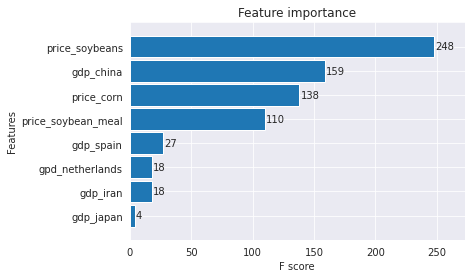

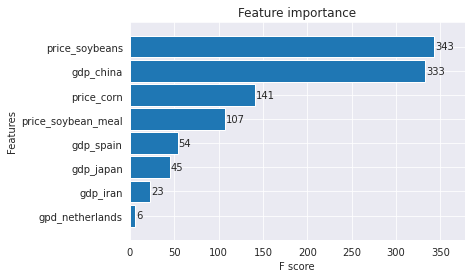

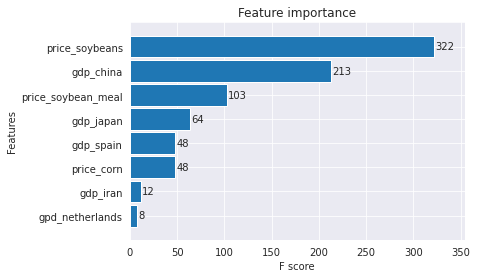

In [262]:
_ = plot_importance(corn_reg, height=0.9)
_ = plot_importance(soybean_reg, height=0.9)
_ = plot_importance(soybean_meal_reg, height=0.9)

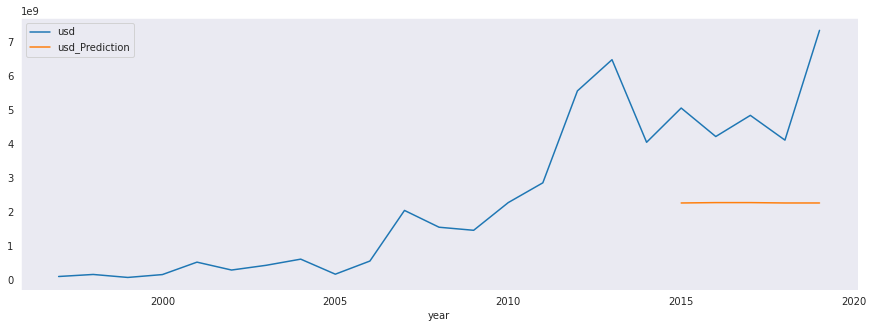

In [263]:
corn_year_test['usd_Prediction'] = corn_reg.predict(Xcorn_year_test)
corn_all = pd.concat([corn_year_train, corn_year_test], sort=False)
_ = corn_all[['usd','usd_Prediction']].plot(figsize=(15, 5))

### The xgboost is not producing good results, will change for another method

## Stats

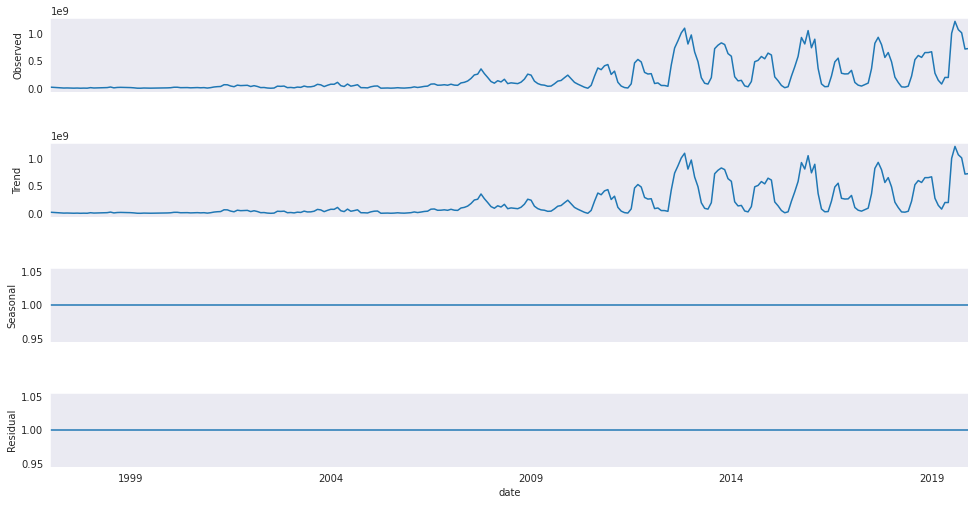

In [264]:


res = sm.tsa.seasonal_decompose(corn.usd,freq=1,model='multiplicative')
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

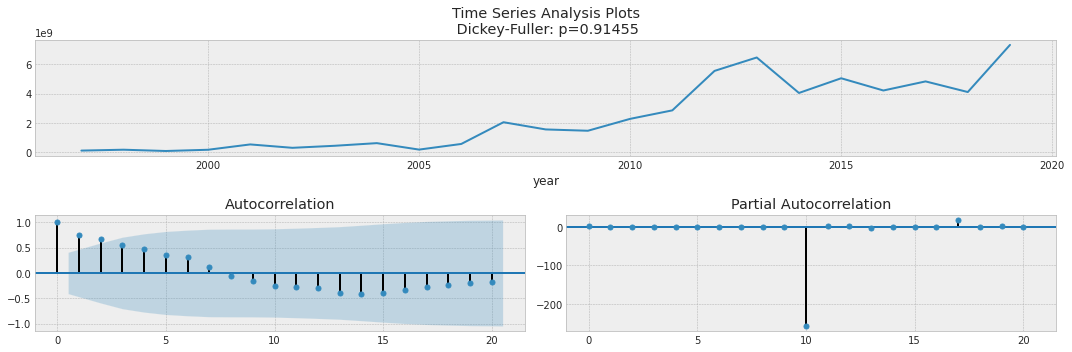

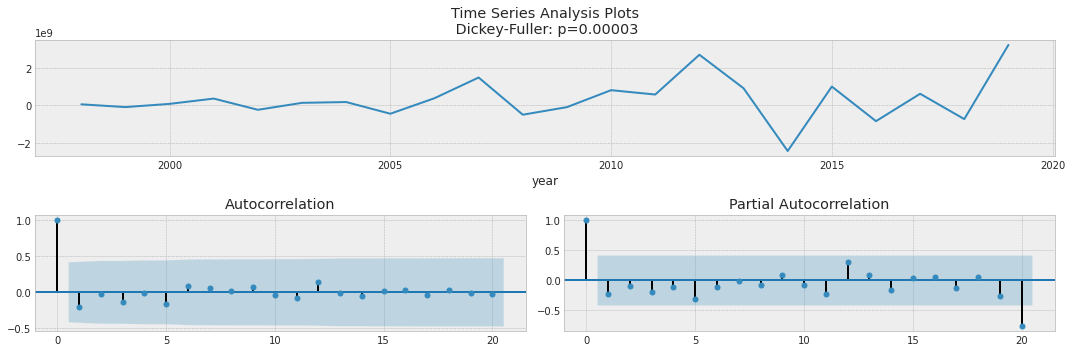

In [265]:

def tsplot(y, lags=None, figsize=BIG_FIG, syle='bmh'):
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(corn_year.usd, lags=20)

# Take the first difference to remove to make the process stationary
corn_diff = corn_year.usd - corn_year.usd.shift(1)

tsplot(corn_diff[1:], lags=20)

<BarContainer object of 20 artists>

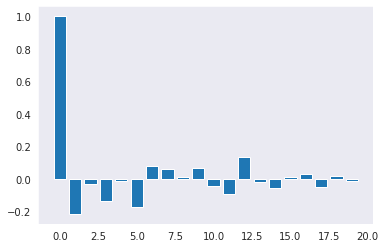

In [266]:
from statsmodels.tsa.stattools import acf, pacf

acf_vals = acf(corn_diff[1:])
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

### Using FBProphet

In [267]:
# Setup and train model and fit
model = Prophet()
model.fit(corn_year_train.reset_index().rename(columns={'year':'ds', 'usd':'y'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


In [268]:
# Predict on training set with model
corn_test_fcst = model.predict(df=corn_year_test.reset_index() \
                                   .rename(columns={'year':'ds'}))

In [269]:
corn_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,6.819827e+09,3.175295e+09,5.896143e+09,6.819827e+09,6.819827e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,0.0,0.0,0.0,4.511791e+09
1,2016-01-01,7.125164e+09,3.564318e+09,6.162887e+09,7.125164e+09,7.125164e+09,-2.293800e+09,-2.293800e+09,-2.293800e+09,-2.293800e+09,-2.293800e+09,-2.293800e+09,0.0,0.0,0.0,4.831364e+09
2,2017-01-01,7.431339e+09,3.967997e+09,6.550402e+09,7.431339e+09,7.431339e+09,-2.248127e+09,-2.248127e+09,-2.248127e+09,-2.248127e+09,-2.248127e+09,-2.248127e+09,0.0,0.0,0.0,5.183212e+09
3,2018-01-01,7.736676e+09,4.177303e+09,6.624225e+09,7.736676e+09,7.736676e+09,-2.292805e+09,-2.292805e+09,-2.292805e+09,-2.292805e+09,-2.292805e+09,-2.292805e+09,0.0,0.0,0.0,5.443871e+09
4,2019-01-01,8.042014e+09,4.479360e+09,6.952406e+09,8.042014e+09,8.042014e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,-2.308035e+09,0.0,0.0,0.0,5.733979e+09


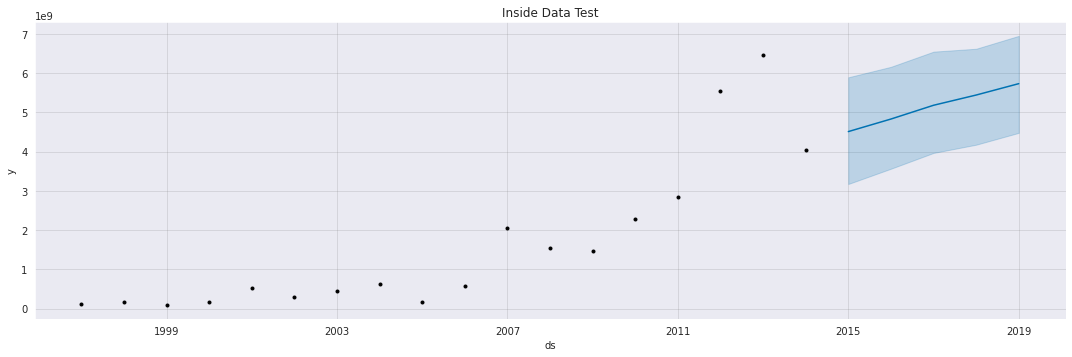

In [270]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(corn_test_fcst,
                 ax=ax)
plt.title("Inside Data Test")
plt.show()

In [271]:
print("MAPE for the predictions on corn: %.2f%%" %mean_absolute_percentage_error(y_true=corn_year_test['usd'],
                   y_pred=corn_test_fcst['yhat']))

MAPE for the predictions on corn: 17.37%


### Now forecasting to outside of the data


In [272]:
# Setup and train model and fit
model = Prophet()
model.fit(corn_year.reset_index().rename(columns={'year':'ds', 'usd':'y'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


In [273]:
corn_fcst = pd.DataFrame(range(2020, 2030), columns=["ds"])
corn_fcst

,ds
0,2020
1,2021
2,2022
3,2023
4,2024
5,2025
6,2026
7,2027
8,2028
9,2029


In [274]:
# Predict on training set with model
corn_fcst = model.predict(df=corn_fcst)

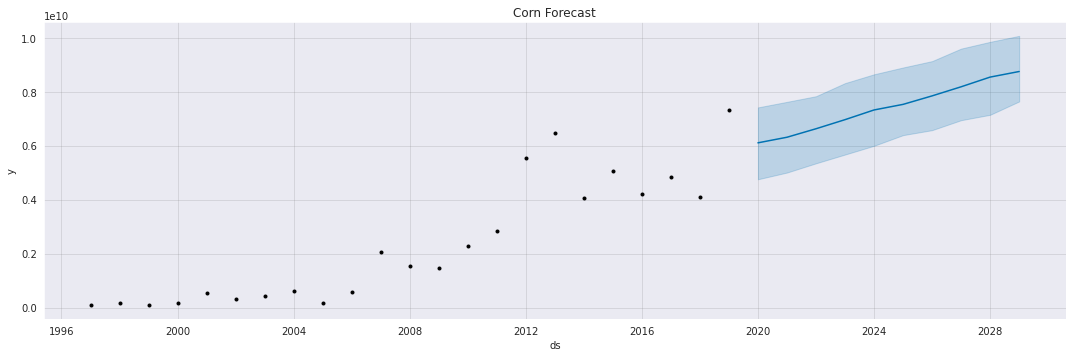

In [275]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(corn_fcst,
                 ax=ax)
plt.title("Corn Forecast")
plt.show()

## To the other two products

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


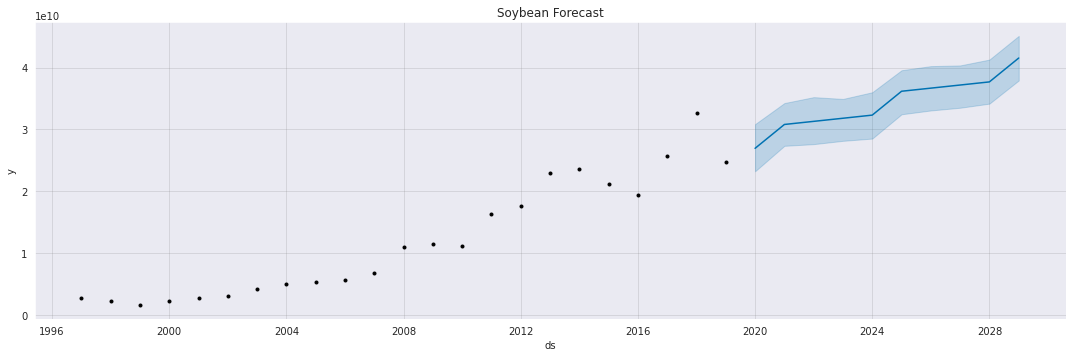

In [276]:
# Setup and train model and fit
model = Prophet()
model.fit(soybean_year.reset_index().rename(columns={'year':'ds', 'usd':'y'}))
soybean_fcst = pd.DataFrame(range(2020, 2030), columns=["ds"])
# Predict on training set with model
soybean_fcst = model.predict(df=soybean_fcst)
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(soybean_fcst,
                 ax=ax)
plt.title("Soybean Forecast")
plt.show()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


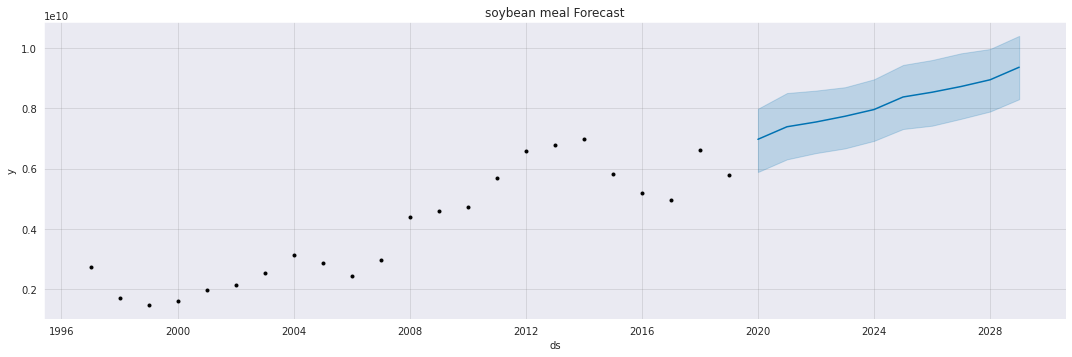

In [277]:
# Setup and train model and fit
model = Prophet()
model.fit(soybean_meal_year.reset_index().rename(columns={'year':'ds', 'usd':'y'}))
soybean_meal_fcst = pd.DataFrame(range(2020, 2030), columns=["ds"])
# Predict on training set with model
soybean_meal_fcst = model.predict(df=soybean_meal_fcst)
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(soybean_meal_fcst,
                 ax=ax)
plt.title("soybean meal Forecast")
plt.show()